```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2022-2023  SINTEF Digital
Copyright (C) 2022-2023 Norwegian Meteorological Institute

This notebook implements the Kelvin waves test case, as reported 
under Case D in "Evaluation of Selected Finite-Difference and 
Finite-Volume Approaches to Rotational Shallow-Water Flow" 
by Holm, Brodtkorb, Broström, Christensen and Sætra.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
%matplotlib inline

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import datetime
import sys

from importlib import reload

plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from gpuocean.utils.BathymetryAndICs import *

In [2]:
#%setup_logging --out galewsky.log
%cuda_context_handler gpu_ctx

In [3]:
image_folder = 'kelvin_images_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(image_folder)
print ("Saving images to " + image_folder)

Saving images to kelvin_images_2023_02_24-12_10_56


# Kelvin waves!
Defining and analysing a test case for Kelvin waves.


In [4]:
def add_hovmuller(i, t, hovmuller_data, data):
    hovmuller_data['t'][i] = t
    for y, hovmuller in hovmuller_data['hovmuller']:
        hovmuller[i,:] = data[y,:]
    hovmuller_data['mass'][i] = data.sum()

def run_sim(sim, i, hovmuller_data):
    if (i>0):
        t = sim.step(12*60*60)
    else:
        t = 0.0

    eta1 = sim.download(interior_domain_only=True)[0]

    if hovmuller_data is not None:
        add_hovmuller(i, t, hovmuller_data, eta1)
    return t
        
def sim_animation(sim, T, sub_dt=10, hovmuller_data=None, kill_left=-1):
    """
    Creates an animation of the simulator based on T frames, with frames sub_dt*sim.dt appart.
    
    If hovmuller_data is provided, cross sections of the simulation is stored in the hovmuller_data arrays.
    hovmuller_data is expected to be of the format:
    hovmuller_data = {'t': 1D array of size T which will contain the simulation times,
            'hovmuller': [(y1, 2D array of size T times nx to store the cross sections),
                          (y2, 2D array of size T times nx to store the cross sections),
                           ...]}
    """
    eta1, u1, v1 = sim.download(interior_domain_only=True)
    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(16, 16))
    domain_extent = [0, sim.nx*sim.dx, 0, sim.ny*sim.dy]
    
    eta_max = eta1.max()*0.5
    hu_max = max(v1.max(), u1.max())
    
    ax_eta = plt.subplot(3,1,1)
    sp_eta = ax_eta.imshow(eta1, interpolation="none", origin='lower', vmin=-eta_max, vmax=eta_max, extent=domain_extent)
    plt.title('eta')
    #ax_eta.colorbar()
    
    ax_u = plt.subplot(3,1,2)
    sp_u = ax_u.imshow(u1, interpolation="none", origin='lower', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    plt.title('hu')
    #ax_u.colorbar()
    
    ax_v = plt.subplot(3,1,3)
    sp_v = ax_v.imshow(v1, interpolation="none", origin='lower', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    plt.title('hv')
    #ax_v.colorbar()
    
    #Helper function which simulates and plots the solution
    def animate(i):
        
        t = run_sim(sim, i, hovmuller_data)
        eta1, u1, v1 = sim.download(interior_domain_only=True)

        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)

        fig.sca(ax_u)
        sp_u.set_data(u1)

        fig.sca(ax_v)
        sp_v.set_data(v1)

        fig.suptitle("Time = {:04.0f} s ({:s})".format(t, sim.__class__.__name__), fontsize=18)
        print(".", end='')

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
    plt.close(fig)
    return anim

In [5]:
# Check solution after one periode:
def plot_periodic_solution(all_data, yticks=[-15,-17.5,-20,-22.5]):
    
    sims = ['CDKLM']
    for full in [False]:
        for sim in sims:
            hovmuller_data = all_data[sim]
            
            # Skip plotting if the simulator is not run
            if hovmuller_data['t'][1] == 0.0:
                continue

            fig = plt.figure(figsize=(10,3))
            nx = hovmuller_data['hovmuller'][0][1].shape[1]
            x_mid = int(nx/2)
            x_start = x_mid - int(nx/2.75)
            x_end   = x_mid + int(nx/2.75)
            if full:
                x_start = 0
                x_end = nx
            x_axis = np.array(range(x_start-x_mid, x_end-x_mid))*all_data['dx']/1000

            for hovmuller, ticks in zip(hovmuller_data['hovmuller'], ['-']):#, '--']):
                colormap=plt.cm.bone
                colorvals = [0.0, 0.3, 0.45, 0.6, 0.7, 0.75, 0.8, 0.825, 0.85, 0.9]

                for idx in [0,1,2,4,6,8]:
                    
                    phase_speed = np.sqrt(all_data['g']*all_data['H'])
                    offset = int(phase_speed*hovmuller_data["t"][idx]/all_data["dx"])

                    label = None
                    if ticks == '-':
                        try:
                            label = str(int(hovmuller_data["t"][idx]/3600))+" h"
                        except:
                            label = None


                    plt.plot(x_axis, -all_data["H"]-np.roll(hovmuller[1][idx], -offset)[x_start:x_end], 
                            ticks, color=colormap(colorvals[idx]), label=label)
                
            if full:
                sim = sim + '_full'
            
            # plt.title(sim)
            plt.ylim([-2.4*all_data['scale_wave']-all_data["H"], -all_data["H"]+0.7*all_data['scale_wave']])
            plt.xlabel(u'$x$ [km]', fontsize='large')#\n\n nx = ' + str(nx) + ', dx = ' + str(all_data['dx']) )
            plt.ylabel(u'$\zeta$ [m]', fontsize='large')
            plt.yticks(yticks)
            plt.legend(loc=2, fontsize='large')
            plt.grid()
            plt.tight_layout()
            plot_filename = image_folder + "/periodic_solution_nx" + str(all_data['nx']) + "_" + sim + ".pdf"
            if all_data['scale_wave'] < 0.9:
                plot_filename = plot_filename.replace('solution_', 'solution_smallwave_')
            plt.savefig(plot_filename)
            plt.savefig(plot_filename.replace('.pdf', '.png'))


def plot_total_mass(all_data):
    fig = plt.figure(figsize=(15,5))
    max_mass = 0.0
    for sim_name in ["CDKLM"]:
        plt.plot(all_data[sim_name]['t'] / all_data['period'], 
                 all_data[sim_name]['mass']-all_data[sim_name]['mass'][0], 
                 label=sim_name)
        max_mass = max(max_mass, np.max(all_data[sim_name]['mass']))
    plt.legend()
    plt.title('Total mass of eta')
    plt.grid()
    print("total mass: ", max_mass)
    plot_filename = image_folder + "/preserved_mass_nx" + str(all_data['nx']) + ".pdf"
    plt.savefig(plot_filename)

In [6]:
def eta_cell(r_i, r_j, rossby_radius, d=1, l=1):
    f_func = 1.0 + np.tanh((-r_i + d*rossby_radius)/(rossby_radius/l))

    return np.exp(-r_j/rossby_radius)*f_func
    
def init_eta(eta, ghost_cells, rossby_radius, sim_args, d=1, l=1):
    ny, nx = eta.shape
    x_0 = nx/2
    y_0 = ghost_cells[2]-0.5
    for j in range(0, ny):
        for i in range(0, nx):
            r_j = np.sqrt((j-y_0)**2)*sim_args["dy"]
            r_i = np.sqrt((i-x_0)**2)*sim_args["dx"]
            
            eta[j,i] = eta_cell(r_i, r_j, rossby_radius, d, l)
            
            
def init_hu(hu, ghost_cells, rossby_radius, geoconst, sim_args):
    ny, nx = hu.shape
    x_0 = nx/2
    y_0 = ghost_cells[2]-0.5
    for j in range(0, ny):
        for i in range(0, nx):
            r_j = np.sqrt((j-y_0)**2)*sim_args["dy"]
            r_i = np.sqrt((i-x_0)**2)*sim_args["dx"]
            
            eta_c = eta_cell(r_i, r_j, rossby_radius)
            hu[j,i] = -geoconst*(-1.0/rossby_radius)*np.sign(j-y_0)*eta_c
            
            
    

Changed parameters:

- g
> 9.81 -> ?
- dx
> 5000 -> ?
- dy
> 10000 -> ?
- depth (smaller depths become critical)
> 100 -> ?

In [7]:
def runPeriodicSims(animate=False, cut_after=None,
                    theta=1.3, hu_push = 1.0, scale_wave=1.0, depth=5, d=2.5, l=2.5):

    # Collecting sim args
    sim_args = {
        "gpu_ctx": gpu_ctx,
        "nx": 400, "ny": 300,
        "dx": 200, "dy": 400,
        "dt": 25,
        "g": 0.01,
        "f": 1.2e-4,
        "coriolis_beta": 0.0,
        "r": 0.0,
        "boundary_conditions": Common.BoundaryConditions(1,2,1,2)
    }
    fvm_args = {
        "rk_order": 2,
        "theta": theta
    }
    
    # Calculating speeds
    rossby_radius = np.sqrt(sim_args["g"]*depth)/sim_args["f"]
    phase_speed = np.sqrt(sim_args['g']*depth)
    period = sim_args['dx']*sim_args['nx']/phase_speed
    geoconst = sim_args['g']*depth/sim_args['f']
    
    T = 10

    print("rossby_radius: ", rossby_radius)
    print("phase_speed:   ", phase_speed)


    # Initialise state
    ghosts = [2,2,2,2]

    dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
                    sim_args["nx"] + ghosts[1]+ghosts[3])

    eta = np.zeros(dataShape, dtype=np.float32, order='C');
    hu = np.zeros(dataShape, dtype=np.float32, order='C');
    hv = np.zeros(dataShape, dtype=np.float32, order='C');
    H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32)*depth

    # d increases: width of bump increases
    # l increases: steepness of slopes of bump increases
    init_eta(eta, ghosts, rossby_radius, sim_args, d=d, l=l)
    init_hu( hu,  ghosts, rossby_radius, geoconst, sim_args)

    if scale_wave != 0:
        eta = eta*scale_wave
        hu = hu*scale_wave
    
    init_args =  {
        "eta0" : eta,
        "hu0"  : hu,
        "hv0"  : hv,
        "H"    : H
    }
    
    
    # Initialise simulation
    sim = CDKLM16.CDKLM16(**sim_args, **init_args, **fvm_args)

    if cut_after is not None:
        T = cut_after
        
    if animate:
        return sim_animation(sim, T, hovmuller_data=None)

    else:
        hovmuller_data = {'CDKLM': {'t': np.zeros(T),
                            'hovmuller': [(0,  np.zeros((T, sim_args["nx"]))), 
                                            (10, np.zeros((T, sim_args["nx"])))],
                            'mass': np.zeros(T)},
                    'nx' : sim_args['nx'],
                    'dx' : sim_args['dx'],
                    'period' : period,
                    'theta' : fvm_args['theta'],
                    'hu_push' : hu_push,
                    'g' : sim_args['g'],
                    'f' : sim_args['f'],
                    'dt' : sim_args['dt'],
                    'H' : depth,
                    'scale_wave': scale_wave
                    }
        for t in range(T):
            run_sim(sim, t, hovmuller_data["CDKLM"])
            print(".", end='')
            print(sim.t/60/60)
    return hovmuller_data

## Small wave

rossby_radius:  3227.486121839514
phase_speed:    0.3872983346207417
.0.0
.12.0
.24.0
.36.0
.48.0
.60.0
.72.0
.84.0
.96.0
.108.0


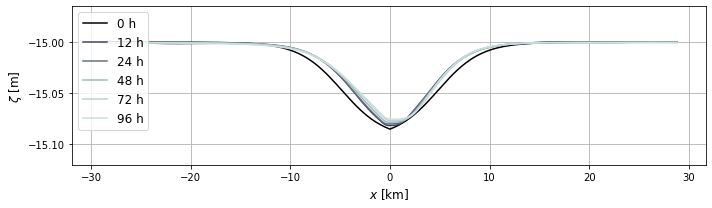

In [8]:
data = runPeriodicSims(depth=15, scale_wave=0.05, d=1.5, l=0.75)
plot_periodic_solution(data, yticks=[-15, -15.05, -15.1])

## Big wave

rossby_radius:  3227.486121839514
phase_speed:    0.3872983346207417
.0.0
.12.0
.24.0
.36.0
.48.0
.60.0
.72.0
.84.0
.96.0
.108.0


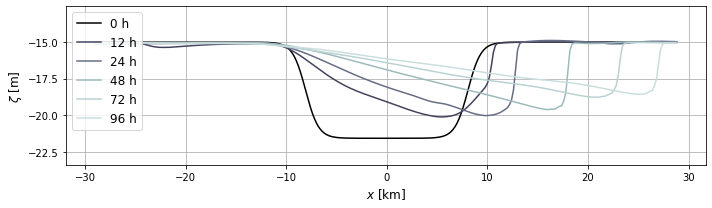

In [9]:
data = runPeriodicSims(depth=15, scale_wave=3.5)
plot_periodic_solution(data)

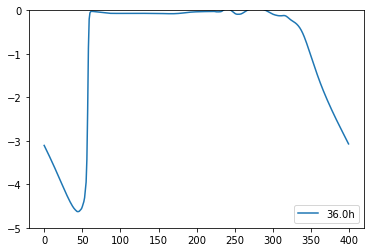

In [10]:
t=3
plt.plot(-np.roll(data["CDKLM"]["hovmuller"][0][1][t], -24*t))
plt.ylim((-5,0))
plt.legend([str(data["CDKLM"]["t"][t]/60/60)+"h"])

total mass:  4554.3779296875


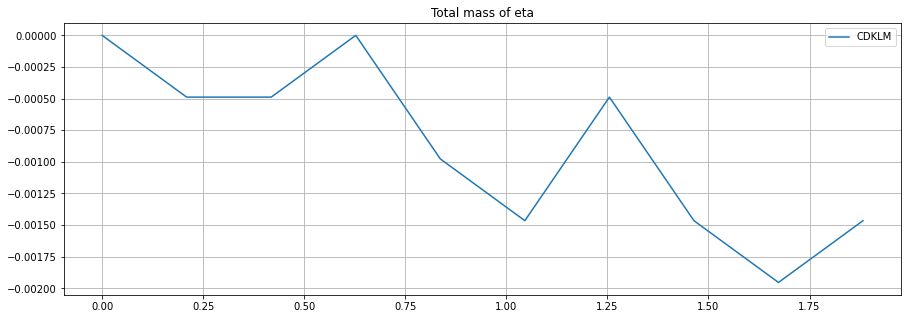

In [11]:
plot_total_mass(data)

In [12]:
runPeriodicSims(depth=15, scale_wave=4, animate=True, cut_after=10)

rossby_radius:  3227.486121839514
phase_speed:    0.3872983346207417
...........

## Sandbox

In [13]:
TEST TEST TEST

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3141, in run_cell_async
    code_ast = compiler.ast_parse(cell, filename=cell_name)
  File "/home/florianb/miniconda3/envs/gpuocean/lib/python3.7/site-packages/IPython/core/compilerop.py", line 101, in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  File "/tmp/ipykernel_1897382/2149561133.py", line 1
    TEST TEST TEST
            ^
SyntaxError: invalid syntax


SyntaxError: invalid syntax (2149561133.py, line 1)

In [ ]:
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": 400, "ny": 300,
    "dx": 200, "dy": 400,
    "dt": 25,
    "g": -0.01,
    "f": 1.2e-4,
    "coriolis_beta": 0.0,
    "r": 0.0,
    "boundary_conditions": Common.BoundaryConditions(1,2,1,2)
}

depth = -20

# # Calculating speeds
rossby_radius = np.sqrt(sim_args["g"]*depth)/sim_args["f"]
phase_speed = np.sqrt(sim_args['g']*depth)
period = sim_args['dx']*sim_args['nx']/phase_speed
geoconst = sim_args['g']*depth/sim_args['f']

print("rossby_radius: ", rossby_radius)
print("phase_speed:   ", phase_speed)
print("period:        ", period)
print("geoconst:      ", geoconst)


In [ ]:
# Initialise state
ghosts = [1,1,1,1]

dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
                sim_args["nx"] + ghosts[1]+ghosts[3])

eta = np.zeros(dataShape, dtype=np.float32, order='C');
hu = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
hv = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);  
H = np.ones(dataShape, dtype=np.float32)*depth

init_eta(eta, ghosts, rossby_radius, sim_args)
init_hu( hu,  ghosts, rossby_radius, geoconst, sim_args)


scale_wave = 1.0
eta = eta*scale_wave
hu = hu*scale_wave


In [ ]:
from gpuocean.SWEsimulators import CTCS

In [ ]:
init_args =  {
    "eta0" : -eta,
    "hu0"  : hu,
    "hv0"  : hv,
    "H"    : H
}


# Initialise simulation
sim = CTCS.CTCS(**sim_args, **init_args, A=50/2)

In [ ]:
sim.step(300)
plt.plot(sim.gpu_data.h0.download(sim.gpu_stream)[2])

In [ ]:
plt.imshow(sim.download()[1][0:50,150:250], vmin=0.0)
plt.colorbar()